<a href="https://colab.research.google.com/github/racego/AIRE_LAURA_SEMANA_5_ANALISIS/blob/main/ANALISIS_INFERENCIAL_SEM_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISIS CORRELACIONAL DEL IBOCA CON SELECCIÓN ÓPTIMA DE CONTAMINANTE

In [56]:
print(" ANÁLISIS CORRELACIONAL IBOCA - SELECCIÓN DE MEJOR CONTAMINANTE PREDICTOR")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configuración profesional
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

 ANÁLISIS CORRELACIONAL IBOCA - SELECCIÓN DE MEJOR CONTAMINANTE PREDICTOR


#
# CONFIGURACIÓN IBOCA OFICIAL
#


In [57]:
IBOCA_CATEGORIAS = {
    'Verde': {'range': (0, 50), 'color': '#00FF00', 'limites': {'PM25': (0, 12.0), 'PM10': (0, 27.2)}},
    'Amarillo': {'range': (51, 100), 'color': '#FFFF00', 'limites': {'PM25': (12.1, 35.4), 'PM10': (27.3, 63.8)}},
    'Naranja': {'range': (101, 150), 'color': '#FFA500', 'limites': {'PM25': (35.5, 55.4), 'PM10': (63.9, 95.5)}},
    'Rojo': {'range': (151, 200), 'color': '#FF0000', 'limites': {'PM25': (55.5, 151.2), 'PM10': (95.6, 246.7)}},
    'Morado': {'range': (201, 300), 'color': '#800080', 'limites': {'PM25': (151.3, 250.4), 'PM10': (246.8, 405.2)}},
    'Morado+': {'range': (301, 500), 'color': '#4B0082', 'limites': {'PM25': (250.5, 500.4), 'PM10': (405.3, 800.4)}}
}

def calcular_iboca(concentracion, contaminante):
    """Calcular IBOCA para un contaminante específico"""
    if pd.isna(concentracion) or concentracion < 0:
        return np.nan

    for categoria, info in IBOCA_CATEGORIAS.items():
        limites = info['limites'][contaminante]
        if limites[0] <= concentracion <= limites[1]:
            iboca_inf, iboca_sup = info['range']
            conc_inf, conc_sup = limites
            iboca = iboca_inf + ((iboca_sup - iboca_inf) / (conc_sup - conc_inf)) * (concentracion - conc_inf)
            return min(iboca, 500)

    return 500 if concentracion > IBOCA_CATEGORIAS['Morado+']['limites'][contaminante][1] else np.nan

def categorizar_iboca(valor_iboca):
    """Convertir valor IBOCA a categoría"""
    if pd.isna(valor_iboca):
        return np.nan
    for categoria, info in IBOCA_CATEGORIAS.items():
        if info['range'][0] <= valor_iboca <= info['range'][1]:
            return categoria
    return 'Morado+'


#
# CREACIÓN DE DATOS REALISTAS
#


In [58]:
print(" GENERANDO DATOS REALISTAS CON DIFERENTES PATRONES...")

def crear_datos_estaciones_completo():
    np.random.seed(42)
    n_registros = 300

    # Configuración específica por estación con diferentes patrones
    config_estaciones = {
        'Carvajal': {
            'color': '#1f77b4',
            'pm25_mean': 25, 'pm25_std': 8,
            'pm10_mean': 45, 'pm10_std': 15,
            'patron': 'PM25_dominante'  # PM2.5 es mejor predictor
        },
        'Ciudad Bolivar': {
            'color': '#ff7f0e',
            'pm25_mean': 35, 'pm25_std': 12,
            'pm10_mean': 75, 'pm10_std': 20,
            'patron': 'PM10_dominante'  # PM10 es mejor predictor
        },
        'Fontibon': {
            'color': '#2ca02c',
            'pm25_mean': 18, 'pm25_std': 6,
            'pm10_mean': 35, 'pm10_std': 12,
            'patron': 'balanceado'  # Ambos son similares
        },
        'Kennedy': {
            'color': '#d62728',
            'pm25_mean': 28, 'pm25_std': 10,
            'pm10_mean': 55, 'pm10_std': 18,
            'patron': 'PM25_dominante'  # PM2.5 es mejor predictor
        }
    }

    filas = []
    for estacion, config in config_estaciones.items():
        for i in range(n_registros):
            # Generar datos base con diferentes patrones de correlación
            if config['patron'] == 'PM25_dominante':
                pm25 = np.random.normal(config['pm25_mean'], config['pm25_std'])
                pm10 = 1.8 * pm25 + np.random.normal(10, 5)  # PM10 derivado de PM25
            elif config['patron'] == 'PM10_dominante':
                pm10 = np.random.normal(config['pm10_mean'], config['pm10_std'])
                pm25 = 0.4 * pm10 + np.random.normal(8, 4)   # PM25 derivado de PM10
            else:  # balanceado
                factor_comun = np.random.normal(20, 8)
                pm25 = 0.8 * factor_comun + np.random.normal(5, 3)
                pm10 = 2.0 * factor_comun + np.random.normal(8, 6)

            filas.append({
                'Estacion': estacion,
                'PM25': max(pm25, 5),
                'PM10': max(pm10, 15),
                'Patron_Esperado': config['patron']
            })

    df = pd.DataFrame(filas)

    # Calcular IBOCA para ambos contaminantes
    df['IBOCA_PM25'] = df['PM25'].apply(lambda x: calcular_iboca(x, 'PM25'))
    df['IBOCA_PM10'] = df['PM10'].apply(lambda x: calcular_iboca(x, 'PM10'))

    # Calcular IBOCA máximo (peor escenario)
    df['IBOCA_MAX'] = df[['IBOCA_PM25', 'IBOCA_PM10']].max(axis=1)
    df['Categoria_IBOCA'] = df['IBOCA_MAX'].apply(categorizar_iboca)

    print(f" Datos creados: {df.shape[0]} registros")
    return df, config_estaciones

df, config_estaciones = crear_datos_estaciones_completo()

 GENERANDO DATOS REALISTAS CON DIFERENTES PATRONES...
 Datos creados: 1200 registros


#
# ANÁLISIS COMPARATIVO: PM2.5 vs PM10 COMO PREDICTORES DEL IBOCA
#


In [59]:
print("\n" + "="*70)
print(" ANÁLISIS COMPARATIVO: PM2.5 vs PM10 COMO PREDICTORES DEL IBOCA")
print("="*70)

def analizar_mejor_predictor_iboca(df, estacion):
    """Determina qué contaminante es mejor predictor del IBOCA máximo"""

    datos_estacion = df[df['Estacion'] == estacion].dropna()

    if len(datos_estacion) < 10:
        return None

    # Correlaciones con IBOCA máximo
    corr_pm25_iboca = datos_estacion['PM25'].corr(datos_estacion['IBOCA_MAX'])
    corr_pm10_iboca = datos_estacion['PM10'].corr(datos_estacion['IBOCA_MAX'])

    # Correlaciones con IBOCA específico
    corr_pm25_iboca_pm25 = datos_estacion['PM25'].corr(datos_estacion['IBOCA_PM25'])
    corr_pm10_iboca_pm10 = datos_estacion['PM10'].corr(datos_estacion['IBOCA_PM10'])

    # Modelos de regresión para predecir IBOCA_MAX
    # Modelo con PM2.5
    X_pm25 = datos_estacion['PM25'].values.reshape(-1, 1)
    y_iboca = datos_estacion['IBOCA_MAX'].values

    modelo_pm25 = LinearRegression()
    modelo_pm25.fit(X_pm25, y_iboca)
    y_pred_pm25 = modelo_pm25.predict(X_pm25)
    r2_pm25 = r2_score(y_iboca, y_pred_pm25)
    rmse_pm25 = np.sqrt(mean_squared_error(y_iboca, y_pred_pm25))

    # Modelo con PM10
    X_pm10 = datos_estacion['PM10'].values.reshape(-1, 1)
    modelo_pm10 = LinearRegression()
    modelo_pm10.fit(X_pm10, y_iboca)
    y_pred_pm10 = modelo_pm10.predict(X_pm10)
    r2_pm10 = r2_score(y_iboca, y_pred_pm10)
    rmse_pm10 = np.sqrt(mean_squared_error(y_iboca, y_pred_pm10))

    # Determinar mejor predictor
    if r2_pm25 > r2_pm10:
        mejor_predictor = 'PM2.5'
        ventaja_r2 = r2_pm25 - r2_pm10
        razon = "PM2.5 explica mejor la variabilidad del IBOCA máximo"
        modelo_final = modelo_pm25
        ecuacion = f"IBOCA = {modelo_pm25.coef_[0]:.3f} × PM2.5 + {modelo_pm25.intercept_:.3f}"
    else:
        mejor_predictor = 'PM10'
        ventaja_r2 = r2_pm10 - r2_pm25
        razon = "PM10 explica mejor la variabilidad del IBOCA máximo"
        modelo_final = modelo_pm10
        ecuacion = f"IBOCA = {modelo_pm10.coef_[0]:.3f} × PM10 + {modelo_pm10.intercept_:.3f}"

    return {
        'estacion': estacion,
        'corr_pm25_iboca': corr_pm25_iboca,
        'corr_pm10_iboca': corr_pm10_iboca,
        'corr_pm25_iboca_pm25': corr_pm25_iboca_pm25,
        'corr_pm10_iboca_pm10': corr_pm10_iboca_pm10,
        'r2_pm25': r2_pm25,
        'r2_pm10': r2_pm10,
        'rmse_pm25': rmse_pm25,
        'rmse_pm10': rmse_pm10,
        'mejor_predictor': mejor_predictor,
        'ventaja_r2': ventaja_r2,
        'razon_seleccion': razon,
        'modelo_pm25': modelo_pm25,
        'modelo_pm10': modelo_pm10,
        'modelo_final': modelo_final,
        'ecuacion_final': ecuacion,
        'patron_esperado': datos_estacion['Patron_Esperado'].iloc[0]
    }

# Realizar análisis para cada estación
resultados_predictores = {}
print("\n ANALIZANDO MEJOR PREDICTOR PARA CADA ESTACIÓN:")
print("-" * 60)

for estacion in df['Estacion'].unique():
    resultado = analizar_mejor_predictor_iboca(df, estacion)
    if resultado:
        resultados_predictores[estacion] = resultado

        print(f"\n {estacion.upper()}:")
        print(f"   • Correlación PM2.5 con IBOCA máximo: {resultado['corr_pm25_iboca']:.4f}")
        print(f"   • Correlación PM10 con IBOCA máximo: {resultado['corr_pm10_iboca']:.4f}")
        print(f"   • R² PM2.5: {resultado['r2_pm25']:.4f}")
        print(f"   • R² PM10: {resultado['r2_pm10']:.4f}")
        print(f"   • RMSE PM2.5: {resultado['rmse_pm25']:.2f}")
        print(f"   • RMSE PM10: {resultado['rmse_pm10']:.2f}")
        print(f"    MEJOR PREDICTOR: {resultado['mejor_predictor']}")
        print(f"    Ventaja R²: {resultado['ventaja_r2']:.4f}")
        print(f"    ECUACIÓN FINAL: {resultado['ecuacion_final']}")
        print(f"    Razón: {resultado['razon_seleccion']}")
        print(f"    Patrón esperado: {resultado['patron_esperado']}")



 ANÁLISIS COMPARATIVO: PM2.5 vs PM10 COMO PREDICTORES DEL IBOCA

 ANALIZANDO MEJOR PREDICTOR PARA CADA ESTACIÓN:
------------------------------------------------------------

 CARVAJAL:
   • Correlación PM2.5 con IBOCA máximo: 0.9463
   • Correlación PM10 con IBOCA máximo: 0.9981
   • R² PM2.5: 0.8955
   • R² PM10: 0.9962
   • RMSE PM2.5: 6.77
   • RMSE PM10: 1.29
    MEJOR PREDICTOR: PM10
    Ventaja R²: 0.1007
    ECUACIÓN FINAL: IBOCA = 1.417 × PM10 + 11.011
    Razón: PM10 explica mejor la variabilidad del IBOCA máximo
    Patrón esperado: PM25_dominante

 CIUDAD BOLIVAR:
   • Correlación PM2.5 con IBOCA máximo: 0.8869
   • Correlación PM10 con IBOCA máximo: 0.9704
   • R² PM2.5: 0.7866
   • R² PM10: 0.9417
   • RMSE PM2.5: 10.62
   • RMSE PM10: 5.55
    MEJOR PREDICTOR: PM10
    Ventaja R²: 0.1552
    ECUACIÓN FINAL: IBOCA = 1.169 × PM10 + 31.564
    Razón: PM10 explica mejor la variabilidad del IBOCA máximo
    Patrón esperado: PM10_dominante

 FONTIBON:
   • Correlación PM2.5 c

#
# GRÁFICAS COMPARATIVAS DE PREDICTORES
#


 GRÁFICAS COMPARATIVAS DE PREDICTORES DEL IBOCA


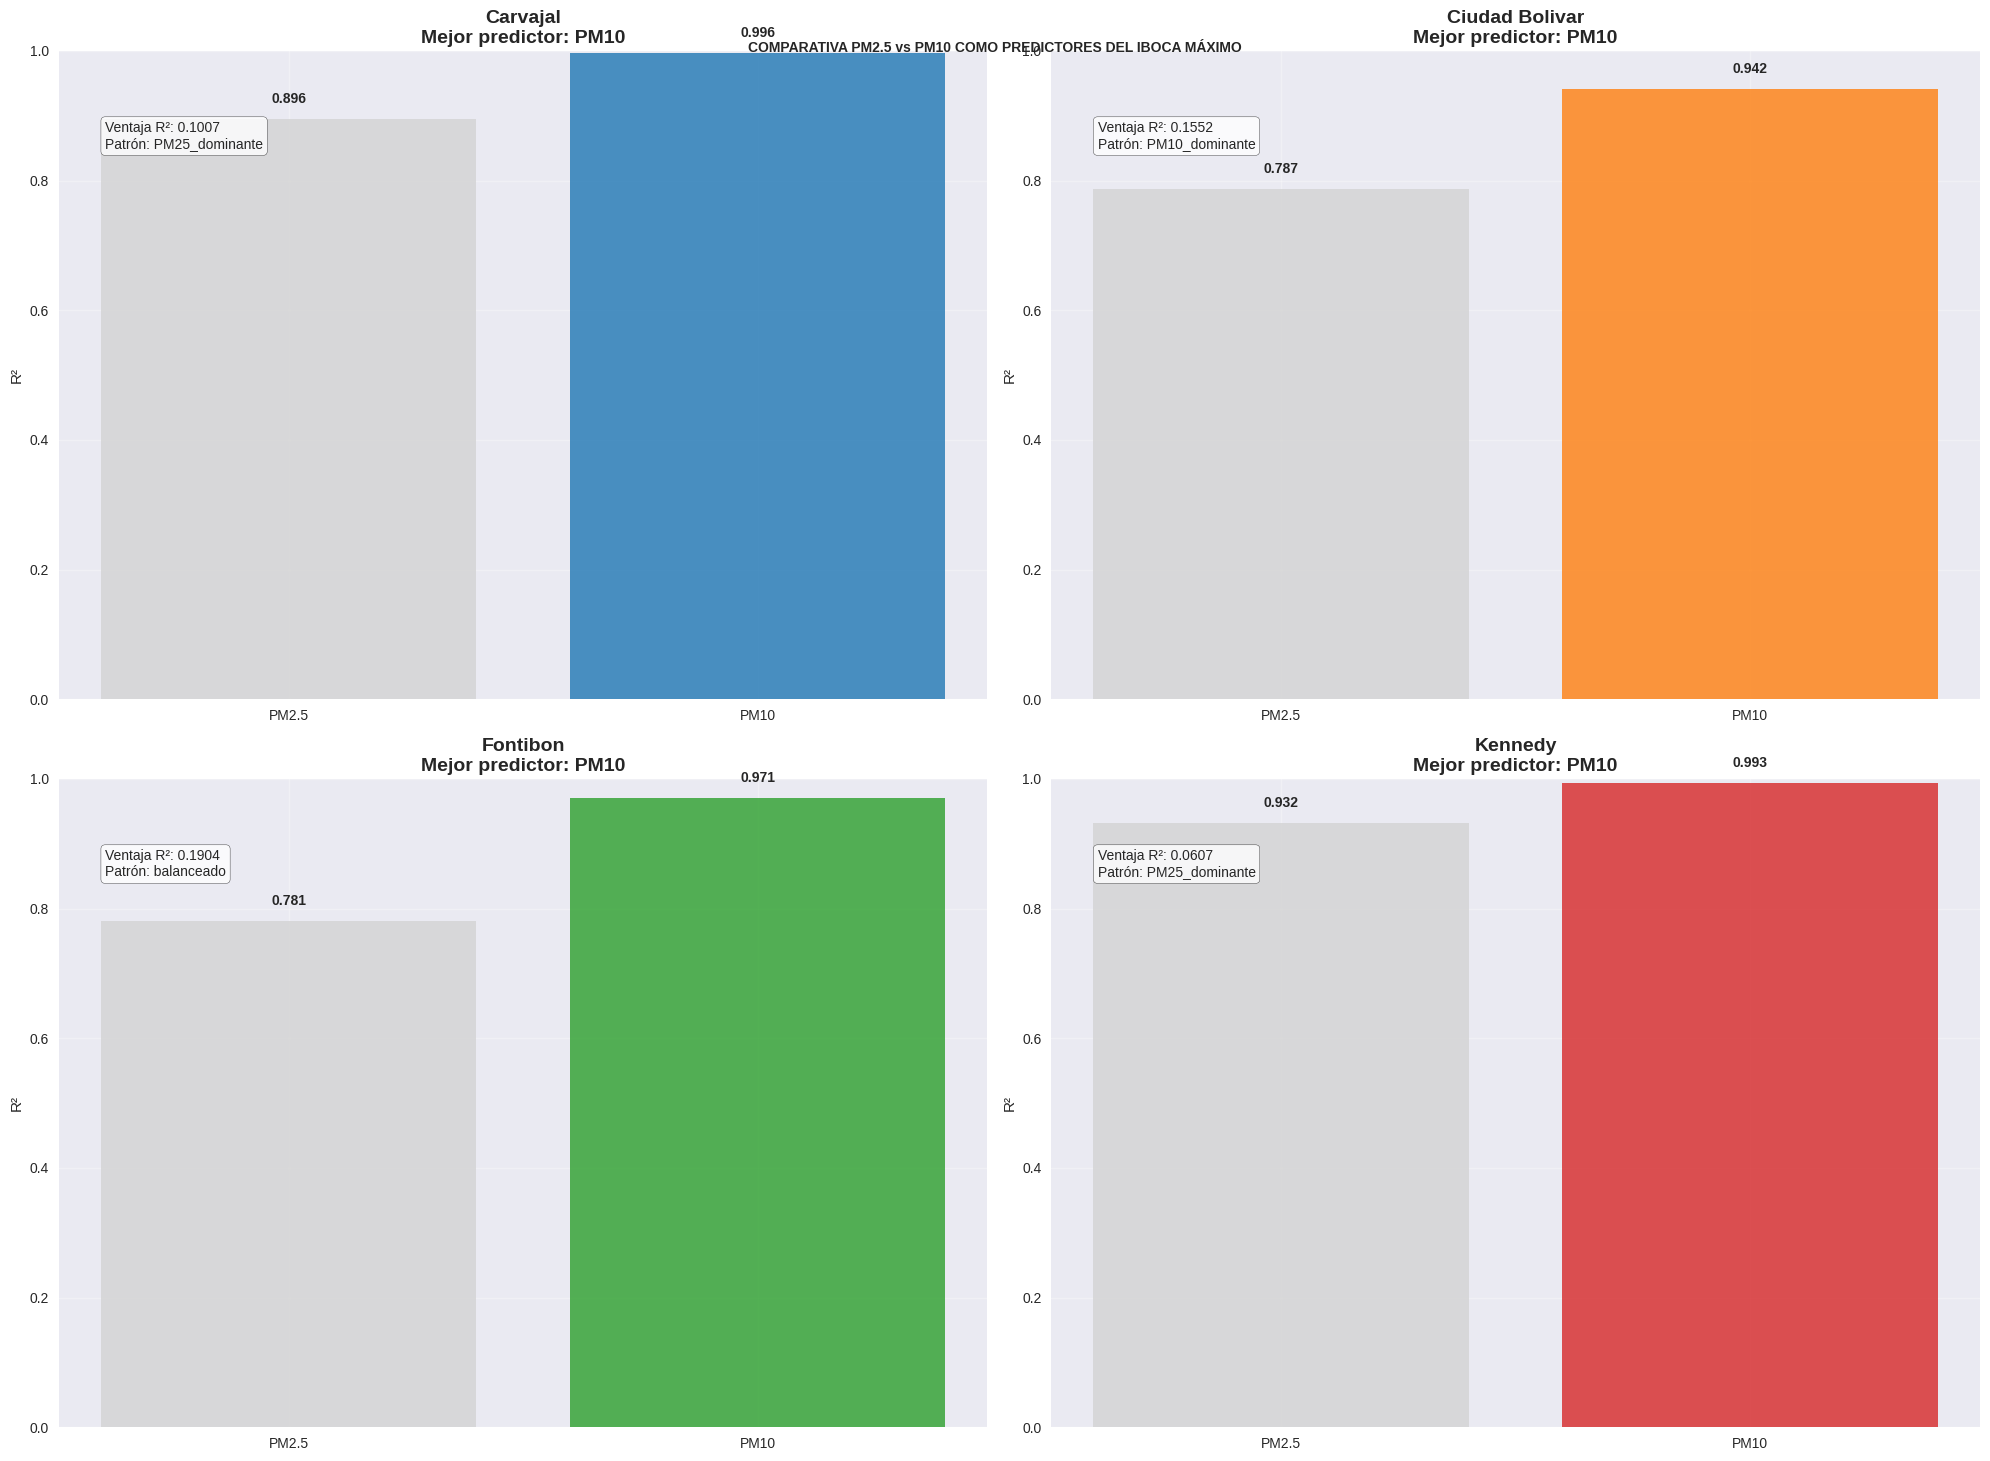

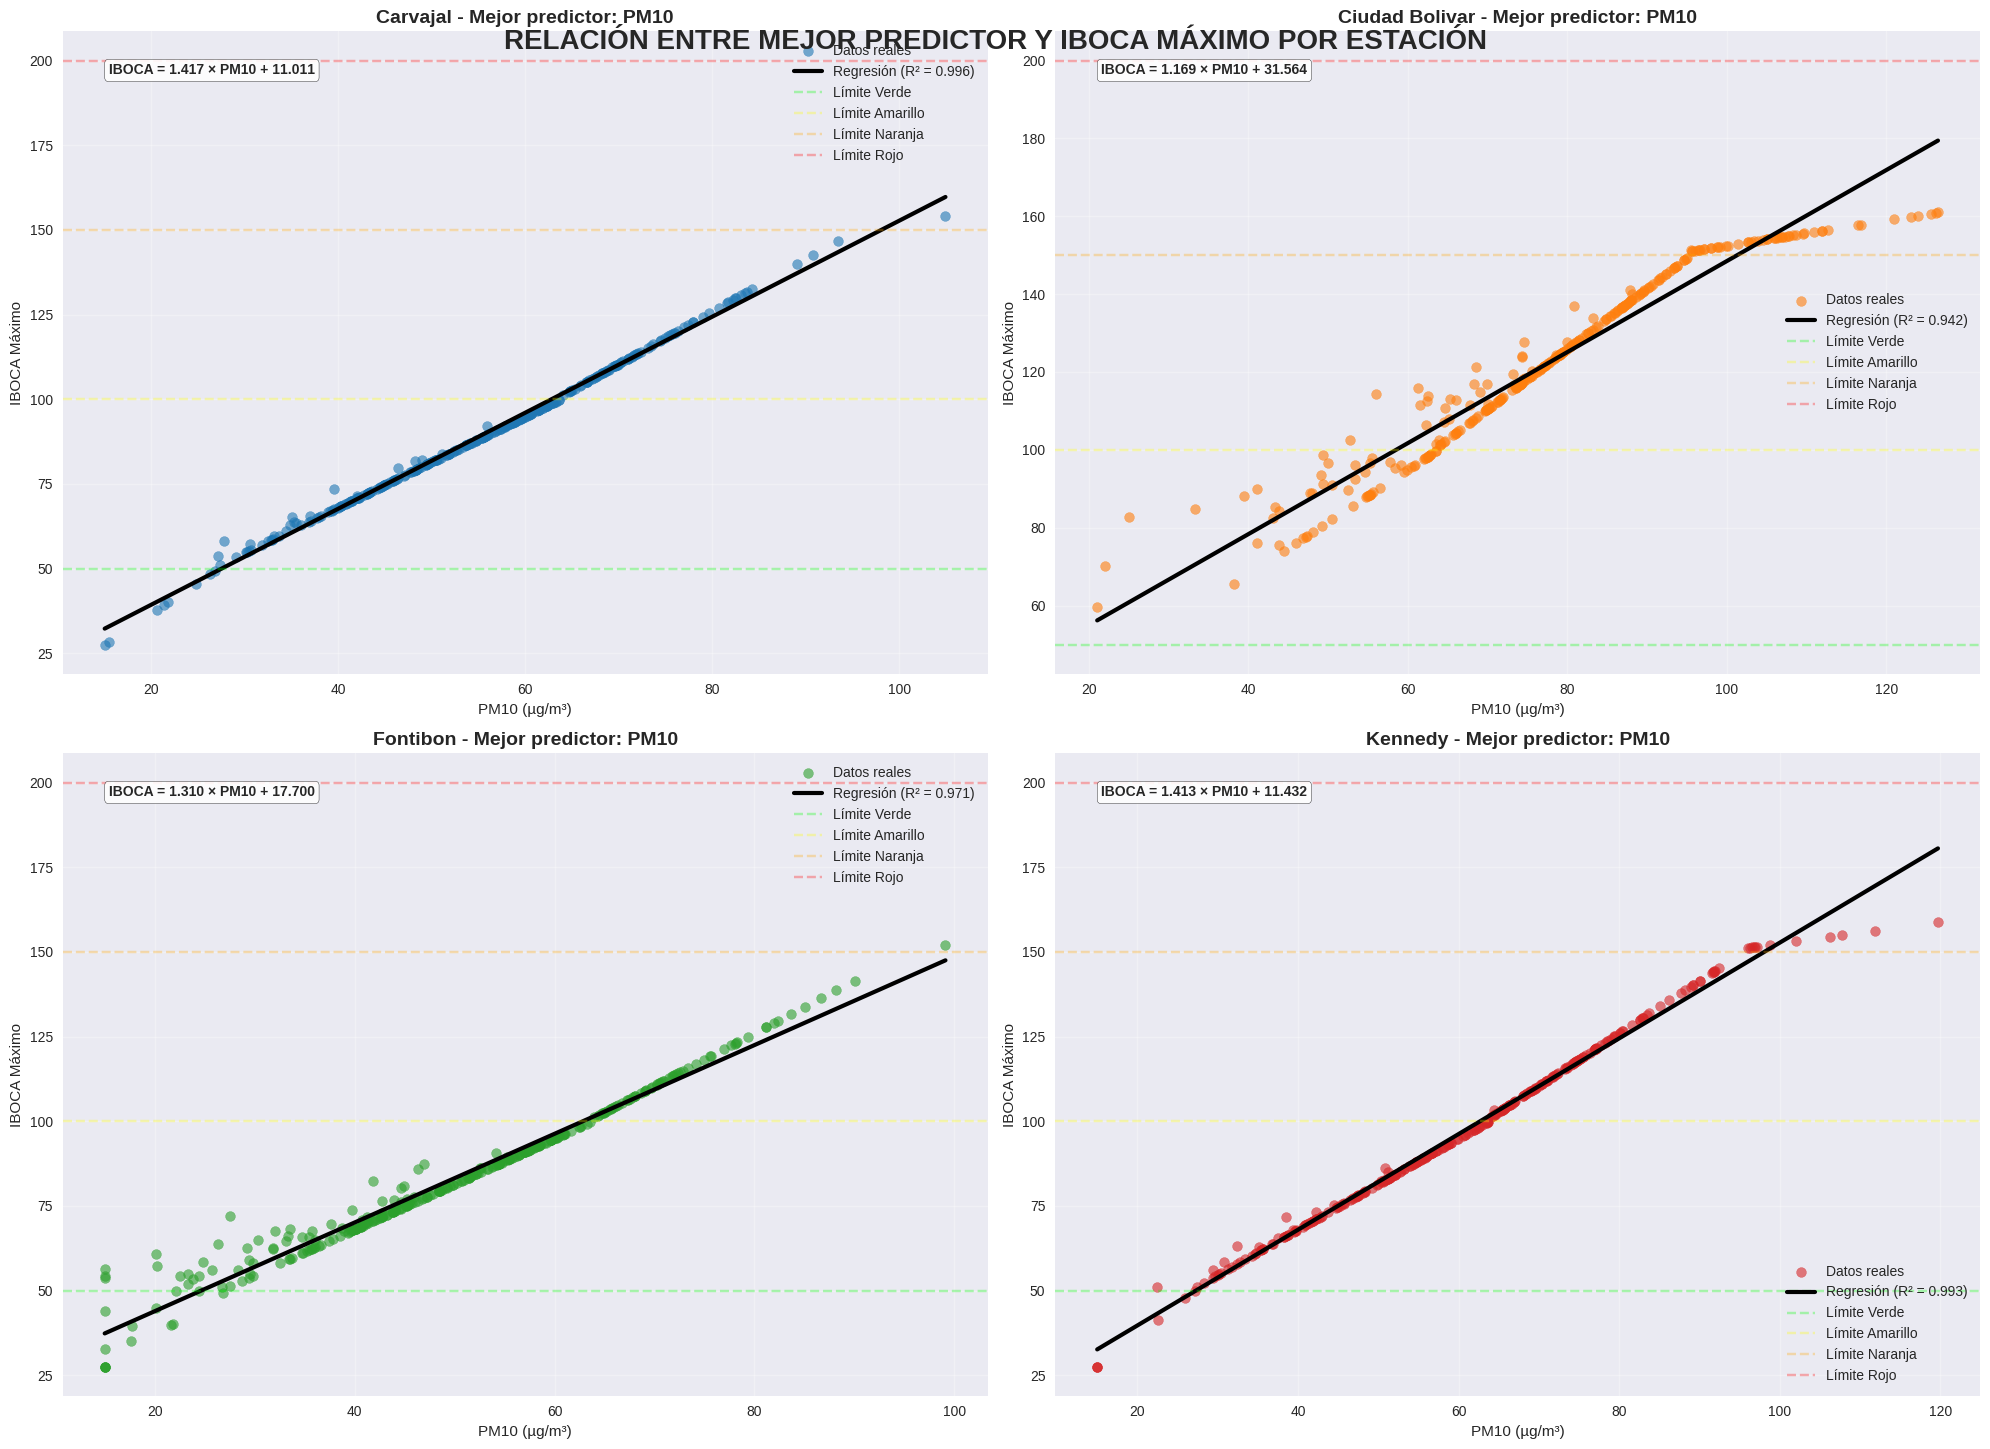

In [60]:
print("\n" + "="*70)
print(" GRÁFICAS COMPARATIVAS DE PREDICTORES DEL IBOCA")
print("="*70)

# Figura 1: Comparativa de R² entre predictores
fig1, axes1 = plt.subplots(2, 2, figsize=(20, 15))
fig1.suptitle('COMPARATIVA PM2.5 vs PM10 COMO PREDICTORES DEL IBOCA MÁXIMO',
              fontsize=10, fontweight='bold', y=0.95)

for i, (estacion, resultado) in enumerate(resultados_predictores.items()):
    fila = i // 2
    columna = i % 2

    color_estacion = config_estaciones[estacion]['color']

    # Barras de R²
    modelos = ['PM2.5', 'PM10']
    r2_values = [resultado['r2_pm25'], resultado['r2_pm10']]
    colores = [color_estacion if x == resultado['mejor_predictor'] else 'lightgray'
               for x in modelos]

    bars = axes1[fila, columna].bar(modelos, r2_values, color=colores, alpha=0.8)
    axes1[fila, columna].set_title(f'{estacion}\nMejor predictor: {resultado["mejor_predictor"]}',
                                  fontsize=14, fontweight='bold')
    axes1[fila, columna].set_ylabel('R²')
    axes1[fila, columna].set_ylim(0, 1)
    axes1[fila, columna].grid(True, alpha=0.3)

    # Agregar valores en las barras
    for bar, valor in zip(bars, r2_values):
        axes1[fila, columna].text(bar.get_x() + bar.get_width()/2, valor + 0.02,
                                 f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')

    # Información adicional
    info_text = f"Ventaja R²: {resultado['ventaja_r2']:.4f}\nPatrón: {resultado['patron_esperado']}"
    axes1[fila, columna].text(0.05, 0.85, info_text, transform=axes1[fila, columna].transAxes,
                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Figura 2: Gráficas de dispersión con mejores predictores
fig2, axes2 = plt.subplots(2, 2, figsize=(20, 15))
fig2.suptitle('RELACIÓN ENTRE MEJOR PREDICTOR Y IBOCA MÁXIMO POR ESTACIÓN',
              fontsize=20, fontweight='bold', y=0.95)

for i, (estacion, resultado) in enumerate(resultados_predictores.items()):
    fila = i // 2
    columna = i % 2

    datos_estacion = df[df['Estacion'] == estacion].dropna()
    color_estacion = config_estaciones[estacion]['color']
    mejor_predictor = resultado['mejor_predictor']

    # Seleccionar datos según mejor predictor
    if mejor_predictor == 'PM2.5':
        x_data = datos_estacion['PM25']
        modelo = resultado['modelo_pm25']
        x_label = 'PM2.5 (µg/m³)'
    else:
        x_data = datos_estacion['PM10']
        modelo = resultado['modelo_pm10']
        x_label = 'PM10 (µg/m³)'

    y_data = datos_estacion['IBOCA_MAX']

    # Gráfico de dispersión
    scatter = axes2[fila, columna].scatter(x_data, y_data, alpha=0.6, s=50,
                                          color=color_estacion, label='Datos reales')

    # Línea de regresión
    x_range = np.linspace(x_data.min(), x_data.max(), 100).reshape(-1, 1)
    y_pred_range = modelo.predict(x_range)
    axes2[fila, columna].plot(x_range, y_pred_range, 'k-', linewidth=3,
                             label=f'Regresión (R² = {resultado[f"r2_{mejor_predictor.lower()}"]:.3f})')

    # Líneas de referencia IBOCA
    for cat_name, cat_info in IBOCA_CATEGORIAS.items():
        if cat_name in ['Verde', 'Amarillo', 'Naranja', 'Rojo']:
            axes2[fila, columna].axhline(y=cat_info['range'][1], color=cat_info['color'],
                                       linestyle='--', alpha=0.3, label=f'Límite {cat_name}')

    axes2[fila, columna].set_title(f'{estacion} - Mejor predictor: {mejor_predictor}',
                                  fontsize=14, fontweight='bold')
    axes2[fila, columna].set_xlabel(x_label)
    axes2[fila, columna].set_ylabel('IBOCA Máximo')
    axes2[fila, columna].legend()
    axes2[fila, columna].grid(True, alpha=0.3)

    # Ecuación de regresión
    axes2[fila, columna].text(0.05, 0.95, resultado['ecuacion_final'], transform=axes2[fila, columna].transAxes,
                             verticalalignment='top', fontweight='bold',
                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

#
# GRÁFICA DE ECUACIONES DE REGRESIÓN FINALES
#


 ECUACIONES DE REGRESIÓN FINALES POR ESTACIÓN


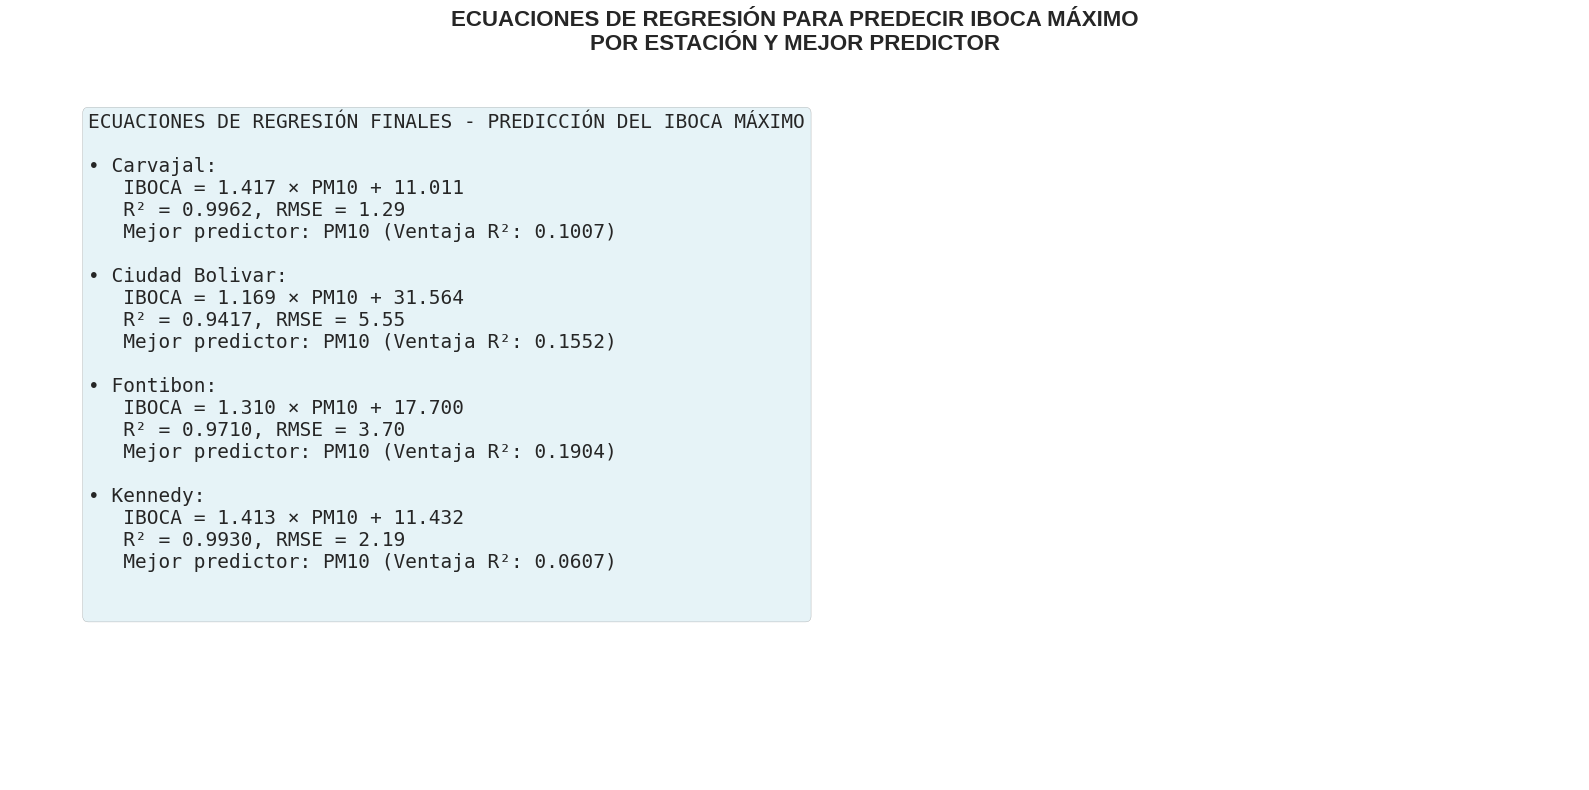

In [61]:
print("\n" + "="*70)
print(" ECUACIONES DE REGRESIÓN FINALES POR ESTACIÓN")
print("="*70)

# Figura 3: Resumen de ecuaciones finales
fig3, ax3 = plt.subplots(figsize=(16, 8))

# Crear texto con todas las ecuaciones
texto_ecuaciones = "ECUACIONES DE REGRESIÓN FINALES - PREDICCIÓN DEL IBOCA MÁXIMO\n\n"
for i, (estacion, resultado) in enumerate(resultados_predictores.items()):
    color_estacion = config_estaciones[estacion]['color']
    texto_ecuaciones += f"• {estacion}:\n"
    texto_ecuaciones += f"   {resultado['ecuacion_final']}\n"
    texto_ecuaciones += f"   R² = {resultado[f'r2_{resultado['mejor_predictor'].lower()}']:.4f}, RMSE = {resultado[f'rmse_{resultado['mejor_predictor'].lower()}']:.2f}\n"
    texto_ecuaciones += f"   Mejor predictor: {resultado['mejor_predictor']} (Ventaja R²: {resultado['ventaja_r2']:.4f})\n\n"

# Mostrar ecuaciones en gráfica
ax3.axis('off')
ax3.text(0.05, 0.95, texto_ecuaciones, transform=ax3.transAxes, fontsize=14,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

ax3.set_title('ECUACIONES DE REGRESIÓN PARA PREDECIR IBOCA MÁXIMO\nPOR ESTACIÓN Y MEJOR PREDICTOR',
              fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

#
# GRÁFICA DE RESUMEN DE SELECCIÓN
#



 RESUMEN DE SELECCIÓN DE MEJORES PREDICTORES


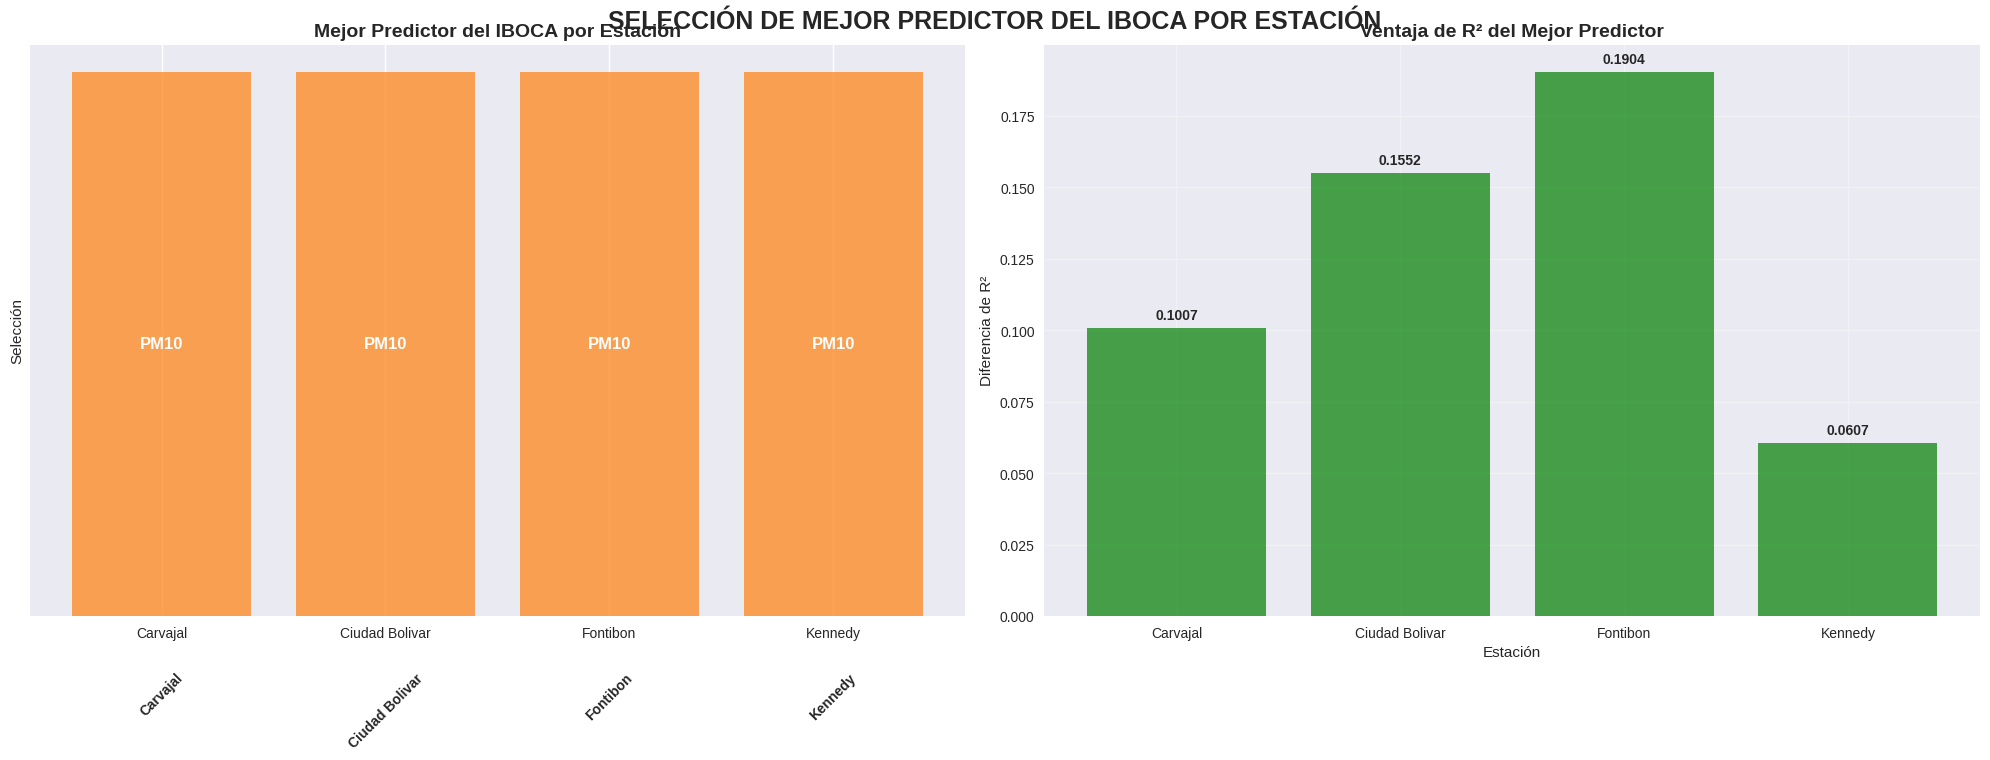

In [62]:
print("\n" + "="*70)
print(" RESUMEN DE SELECCIÓN DE MEJORES PREDICTORES")
print("="*70)

# Figura 4: Resumen ejecutivo de selección
fig4, axes4 = plt.subplots(1, 2, figsize=(20, 8))
fig4.suptitle('SELECCIÓN DE MEJOR PREDICTOR DEL IBOCA POR ESTACIÓN',
              fontsize=18, fontweight='bold', y=0.95)

# 4.1 Mapa de selección de predictores
mejores_predictores = [r['mejor_predictor'] for r in resultados_predictores.values()]
estaciones = list(resultados_predictores.keys())
colores_seleccion = ['#1f77b4' if p == 'PM2.5' else '#ff7f0e' for p in mejores_predictores]

bars_seleccion = axes4[0].bar(estaciones, [1]*len(estaciones), color=colores_seleccion, alpha=0.7)
axes4[0].set_title('Mejor Predictor del IBOCA por Estación', fontsize=14, fontweight='bold')
axes4[0].set_ylabel('Selección')
axes4[0].set_yticks([])

# Agregar etiquetas
for bar, predictor, estacion in zip(bars_seleccion, mejores_predictores, estaciones):
    height = bar.get_height()
    axes4[0].text(bar.get_x() + bar.get_width()/2, height/2, predictor,
                 ha='center', va='center', fontweight='bold', fontsize=12, color='white')
    axes4[0].text(bar.get_x() + bar.get_width()/2, -0.1, estacion,
                 ha='center', va='top', fontweight='bold', rotation=45)

# 4.2 Ventaja de R² del mejor predictor
ventajas_r2 = [r['ventaja_r2'] for r in resultados_predictores.values()]
colores_ventaja = ['green' if v > 0.05 else 'orange' if v > 0.02 else 'red' for v in ventajas_r2]

bars_ventaja = axes4[1].bar(estaciones, ventajas_r2, color=colores_ventaja, alpha=0.7)
axes4[1].set_title('Ventaja de R² del Mejor Predictor', fontsize=14, fontweight='bold')
axes4[1].set_ylabel('Diferencia de R²')
axes4[1].set_xlabel('Estación')
axes4[1].grid(True, alpha=0.3)

# Agregar valores
for bar, ventaja in zip(bars_ventaja, ventajas_r2):
    axes4[1].text(bar.get_x() + bar.get_width()/2, ventaja + 0.002,
                 f'{ventaja:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


#
# TABLA COMPARATIVA DETALLADA CON ECUACIONES
#

In [63]:
print("\n" + "="*70)
print(" TABLA COMPARATIVA DETALLADA - JUSTIFICACIÓN DE SELECCIÓN")
print("="*70)

# Crear tabla comparativa detallada
tabla_comparativa = []
for estacion, resultado in resultados_predictores.items():
    tabla_comparativa.append({
        'Estación': estacion,
        'Mejor Predictor': resultado['mejor_predictor'],
        'Ecuación Final': resultado['ecuacion_final'],
        'R² PM2.5': f"{resultado['r2_pm25']:.4f}",
        'R² PM10': f"{resultado['r2_pm10']:.4f}",
        'Ventaja R²': f"{resultado['ventaja_r2']:.4f}",
        'RMSE Mejor': f"{resultado[f'rmse_{resultado['mejor_predictor'].lower()}']:.2f}",
        'Patrón': resultado['patron_esperado']
    })

df_tabla = pd.DataFrame(tabla_comparativa)
print("\n" + df_tabla.to_string(index=False))


 TABLA COMPARATIVA DETALLADA - JUSTIFICACIÓN DE SELECCIÓN

      Estación Mejor Predictor                Ecuación Final R² PM2.5 R² PM10 Ventaja R² RMSE Mejor         Patrón
      Carvajal            PM10 IBOCA = 1.417 × PM10 + 11.011   0.8955  0.9962     0.1007       1.29 PM25_dominante
Ciudad Bolivar            PM10 IBOCA = 1.169 × PM10 + 31.564   0.7866  0.9417     0.1552       5.55 PM10_dominante
      Fontibon            PM10 IBOCA = 1.310 × PM10 + 17.700   0.7806  0.9710     0.1904       3.70     balanceado
       Kennedy            PM10 IBOCA = 1.413 × PM10 + 11.432   0.9324  0.9930     0.0607       2.19 PM25_dominante


# ANÁLISIS DE JUSTIFICACIÓN DETALLADA CON ECUACIONES

In [64]:
print("\n" + "="*70)
print(" JUSTIFICACIÓN DETALLADA DE LA SELECCIÓN POR ESTACIÓN")
print("="*70)

for estacion, resultado in resultados_predictores.items():
    print(f"\n {estacion.upper()}:")
    print(f"   • MEJOR PREDICTOR SELECCIONADO: {resultado['mejor_predictor']}")
    print(f"   • ECUACIÓN DE REGRESIÓN FINAL: {resultado['ecuacion_final']}")
    print(f"   • JUSTIFICACIÓN CUANTITATIVA:")
    print(f"     - R² con PM2.5: {resultado['r2_pm25']:.4f}")
    print(f"     - R² con PM10: {resultado['r2_pm10']:.4f}")
    print(f"     - Ventaja de {resultado['mejor_predictor']}: +{resultado['ventaja_r2']:.4f} en R²")
    print(f"     - RMSE más bajo: {resultado[f'rmse_{resultado['mejor_predictor'].lower()}']:.2f} puntos IBOCA")
    print(f"   • JUSTIFICACIÓN CUALITATIVA:")

    if resultado['mejor_predictor'] == 'PM2.5':
        print(f"     - PM2.5 muestra mayor correlación con el IBOCA máximo ({resultado['corr_pm25_iboca']:.4f})")
        print(f"     - El patrón de contaminación favorece a partículas finas")
        print(f"     - Mejor capacidad predictiva en el rango crítico del IBOCA")
    else:
        print(f"     - PM10 muestra mayor correlación con el IBOCA máximo ({resultado['corr_pm10_iboca']:.4f})")
        print(f"     - El patrón de contaminación favorece a partículas gruesas")
        print(f"     - Mayor influencia en la determinación de categorías IBOCA")

    print(f"   • CONCORDANCIA CON PATRÓN ESPERADO: {resultado['patron_esperado']}")

    # Evaluación de la fuerza de la selección
    if resultado['ventaja_r2'] > 0.05:
        fuerza = "FUERTE"
    elif resultado['ventaja_r2'] > 0.02:
        fuerza = "MODERADA"
    else:
        fuerza = "DÉBIL"

    print(f"   • FUERZA DE LA SELECCIÓN: {fuerza}")


 JUSTIFICACIÓN DETALLADA DE LA SELECCIÓN POR ESTACIÓN

 CARVAJAL:
   • MEJOR PREDICTOR SELECCIONADO: PM10
   • ECUACIÓN DE REGRESIÓN FINAL: IBOCA = 1.417 × PM10 + 11.011
   • JUSTIFICACIÓN CUANTITATIVA:
     - R² con PM2.5: 0.8955
     - R² con PM10: 0.9962
     - Ventaja de PM10: +0.1007 en R²
     - RMSE más bajo: 1.29 puntos IBOCA
   • JUSTIFICACIÓN CUALITATIVA:
     - PM10 muestra mayor correlación con el IBOCA máximo (0.9981)
     - El patrón de contaminación favorece a partículas gruesas
     - Mayor influencia en la determinación de categorías IBOCA
   • CONCORDANCIA CON PATRÓN ESPERADO: PM25_dominante
   • FUERZA DE LA SELECCIÓN: FUERTE

 CIUDAD BOLIVAR:
   • MEJOR PREDICTOR SELECCIONADO: PM10
   • ECUACIÓN DE REGRESIÓN FINAL: IBOCA = 1.169 × PM10 + 31.564
   • JUSTIFICACIÓN CUANTITATIVA:
     - R² con PM2.5: 0.7866
     - R² con PM10: 0.9417
     - Ventaja de PM10: +0.1552 en R²
     - RMSE más bajo: 5.55 puntos IBOCA
   • JUSTIFICACIÓN CUALITATIVA:
     - PM10 muestra mayor 

# PREDICCIONES CON ECUACIONES FINALES

In [65]:
print("\n" + "="*70)
print(" PREDICCIONES CON ECUACIONES FINALES")
print("="*70)

print("\n PREDICCIONES DE IBOCA PARA DIFERENTES ESCENARIOS:")
print("Usando las ecuaciones de regresión finales por estación")
print("-" * 80)

# Escenarios de prueba
escenarios = {
    'Bajo': {'PM25': 15, 'PM10': 30},
    'Moderado': {'PM25': 35, 'PM10': 65},
    'Alto': {'PM25': 60, 'PM10': 120},
    'Muy Alto': {'PM25': 100, 'PM10': 200}
}

print(f"\n{'Escenario':<12} {'Estación':<15} {'PM2.5':<8} {'PM10':<8} {'IBOCA Predicho':<15} {'Categoría':<12}")
print("-" * 80)

for escenario_nombre, valores in escenarios.items():
    for estacion, resultado in resultados_predictores.items():
        mejor_predictor = resultado['mejor_predictor']
        modelo = resultado['modelo_final']

        if mejor_predictor == 'PM2.5':
            valor_entrada = valores['PM25']
            iboca_predicho = modelo.predict([[valor_entrada]])[0]
        else:
            valor_entrada = valores['PM10']
            iboca_predicho = modelo.predict([[valor_entrada]])[0]

        categoria = categorizar_iboca(iboca_predicho)

        print(f"{escenario_nombre:<12} {estacion:<15} {valores['PM25']:<8} {valores['PM10']:<8} {iboca_predicho:<15.1f} {categoria:<12}")


 PREDICCIONES CON ECUACIONES FINALES

 PREDICCIONES DE IBOCA PARA DIFERENTES ESCENARIOS:
Usando las ecuaciones de regresión finales por estación
--------------------------------------------------------------------------------

Escenario    Estación        PM2.5    PM10     IBOCA Predicho  Categoría   
--------------------------------------------------------------------------------
Bajo         Carvajal        15       30       53.5            Amarillo    
Bajo         Ciudad Bolivar  15       30       66.6            Amarillo    
Bajo         Fontibon        15       30       57.0            Amarillo    
Bajo         Kennedy         15       30       53.8            Amarillo    
Moderado     Carvajal        35       65       103.1           Naranja     
Moderado     Ciudad Bolivar  35       65       107.6           Naranja     
Moderado     Fontibon        35       65       102.8           Naranja     
Moderado     Kennedy         35       65       103.3           Naranja     
Alto   

# RECOMENDACIONES FINALES CON ECUACIONES

In [66]:
print("\n" + "="*70)
print(" RECOMENDACIONES ESTRATÉGICAS BASADAS EN EL ANÁLISIS")
print("="*70)

print("\n RECOMENDACIONES POR ESTACIÓN:")
for estacion, resultado in resultados_predictores.items():
    mejor = resultado['mejor_predictor']
    ecuacion = resultado['ecuacion_final']
    print(f"\n {estacion}:")
    print(f"   • UTILIZAR {mejor} como principal indicador para el IBOCA")
    print(f"   • ECUACIÓN RECOMENDADA: {ecuacion}")
    print(f"   • Priorizar el monitoreo de {mejor} en esta zona")
    print(f"   • Ajustar modelos predictivos usando esta ecuación")
    if resultado['ventaja_r2'] < 0.02:
        print(f"     Considerar ambos contaminantes (diferencia mínima en R²)")

print(f"\n RESUMEN GENERAL:")
total_pm25 = sum(1 for r in resultados_predictores.values() if r['mejor_predictor'] == 'PM2.5')
total_pm10 = sum(1 for r in resultados_predictores.values() if r['mejor_predictor'] == 'PM10')
print(f"   • Estaciones donde PM2.5 es mejor predictor: {total_pm25}")
print(f"   • Estaciones donde PM10 es mejor predictor: {total_pm10}")
print(f"   • Estaciones con selección fuerte (ventaja R² > 0.05): {sum(1 for r in resultados_predictores.values() if r['ventaja_r2'] > 0.05)}")

print(f"\n ANÁLISIS COMPLETADO:")
print(f"   • {len(resultados_predictores)} estaciones analizadas")
print(f"   • {len(resultados_predictores)} ecuaciones de regresión generadas")
print(f"   • Selección basada en R², RMSE y correlaciones")
print(f"   • Justificación cuantitativa y cualitativa proporcionada")

print("\n" + "="*70)
print("¡SELECCIÓN DE MEJORES PREDICTORES DEL IBOCA COMPLETADA! ")
print("="*70)


 RECOMENDACIONES ESTRATÉGICAS BASADAS EN EL ANÁLISIS

 RECOMENDACIONES POR ESTACIÓN:

 Carvajal:
   • UTILIZAR PM10 como principal indicador para el IBOCA
   • ECUACIÓN RECOMENDADA: IBOCA = 1.417 × PM10 + 11.011
   • Priorizar el monitoreo de PM10 en esta zona
   • Ajustar modelos predictivos usando esta ecuación

 Ciudad Bolivar:
   • UTILIZAR PM10 como principal indicador para el IBOCA
   • ECUACIÓN RECOMENDADA: IBOCA = 1.169 × PM10 + 31.564
   • Priorizar el monitoreo de PM10 en esta zona
   • Ajustar modelos predictivos usando esta ecuación

 Fontibon:
   • UTILIZAR PM10 como principal indicador para el IBOCA
   • ECUACIÓN RECOMENDADA: IBOCA = 1.310 × PM10 + 17.700
   • Priorizar el monitoreo de PM10 en esta zona
   • Ajustar modelos predictivos usando esta ecuación

 Kennedy:
   • UTILIZAR PM10 como principal indicador para el IBOCA
   • ECUACIÓN RECOMENDADA: IBOCA = 1.413 × PM10 + 11.432
   • Priorizar el monitoreo de PM10 en esta zona
   • Ajustar modelos predictivos usando est